# Modeling and Evaluation

This notebook contains all related to predictive modeling and evaluation.

### Methodology

The methodology used is an adaptation of Crisp-DM. Currently, we are the steps Modeling and Evaluation:
1. Domain Understanding
2. Data Understanding
4. Data Preparation
5. **Modeling**
6. **Evaluation**



### Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, RandomizedSearchCV
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import cross_decomposition
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import minmax_scale, scale
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest,  f_regression, mutual_info_regression
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from sklearn.decomposition import PCA
from skrebate import ReliefF, SURF
from sklearn.datasets import load_boston, load_diabetes, fetch_california_housing
import pickle
import scipy

### Constants

In [30]:
#data_url =  "https://raw.githubusercontent.com/Naio/aasa-stability-prediction/master/data/processed/"
seed = 10 #Seed for controlling any random procedure during the experiments

### Data loading and preprocessing

In [87]:
#Generator that yields ready-to-use datasets
def datasets():
    datasets_names = ['p1STN', 'p4LYZ', 'p1BPI', 'HLYZ']
    data_url = 'https://raw.githubusercontent.com/Naio/aasa-stability-prediction/master/data/processed/original/'
    
    for dataset_name in datasets_names:
        protein_dataset = pd.read_csv(data_url + dataset_name + '.csv')
        protein_dataset = preprocess_dataset(protein_dataset)
        features, target = split_features_and_target(protein_dataset)
        
        yield {'name': dataset_name, 'features': features, 'target': target}

In [88]:
def preprocess_dataset(df):
    
    #Discard of those descriptors that are highly correlated
    df = discard_highly_correlated_descriptors(df)
    
    #Feature selection
    #Note: This implementation is able to work even if data is not normalized.
    df = select_subset_of_features_SURF(df, number_of_features)
    
    #Z-Score Normalization
    df = normalize_data(df)
    return df

In [78]:
#Discards descriptors that are highly correlated at least with one other descriptor.
#The threshold is an absolute Pearson's r greater than 0.99 
def discard_highly_correlated_descriptors(df):
    
    #Calculates the absolute Pearson's r correlation matrix. Both -1 and 1 are highly correlated.
    correlations = df.corr().abs()
    
    #Gets the correlation matrix upper triangular.
    upper_corr = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))
    
    #Discards the descriptors
    to_drop = [column for column in upper_corr.columns if any(upper_corr[column] > 0.99)]
    return df.drop(columns=to_drop)

In [79]:
def select_subset_of_features_SURF(df, n_features):
    features_importance = calculate_features_importance(df, n_features)
    selected_features = select_n_most_important_features(features_importance, n_features)
    filtered_df = filter_selected_columns(df, selected_features)
    return filtered_df

def calculate_features_importance(df, n_features):
    features, target = split_features_and_target(df)
    
    rlf = SURF(n_features_to_select=n_features)
    rlf.fit(features, target)
    
    return pd.DataFrame({'feature_name':df.iloc[:, 2:].columns, 
                         'importance': rlf.feature_importances_})

def select_n_most_important_features(features_importance, n_features):
    return features_importance.sort_values(by='importance', ascending=False).head(n_features)['feature_name'].tolist()

def filter_selected_columns(df, columns):
    selected = ['id', 'stability']
    selected.extend(columns)
    return df[selected]

In [80]:
#Returns a dataset with normalized descriptors using Z-Score
def normalize_data(df):
    
    #Only descriptores are normalized, so we set apart the stability and mutation name attributes from the original dataset
    mutation_stability = df.iloc[:, 0:2]
    
    #Setting apart the descriptors data
    descriptors = df.iloc[:, 2:]
                      
    #Normalizing the descriptors using Z-Score
    normalized_descriptors = pd.DataFrame(scale(descriptors), columns=descriptors.columns)
    
    #Joining stability and mutation name to the normalized descriptors
    normalized_data = mutation_stability.join(normalized_descriptors)
    
    return normalized_data

In [81]:
#Returns descriptors and target values as numpy arrays
def split_features_and_target(df):
    features = df.iloc[:, 2:].to_numpy()
    target =  df.iloc[:,1].to_numpy()
    return features, target

### Defining hyperparameter grids
Each algorithm has its corresponding hyperparameter grid for later use in grid search inner cross-validation loop.

In [82]:
least_squares_grid = {} #Ordinary least square doesn't have hyperparamters

alpha_range = np.logspace(-6, 6, 13)
ridge_grid = {'alpha' : alpha_range} #Alpha between 1.e-06 and 1.e+06
lasso_grid = {'alpha' : alpha_range} 

pls_grid = {'n_components': np.linspace(start = 2, stop=25, num=100).astype(int)} #Between 2 and 25 Principal Components
c_range = np.logspace(-6, 6, 13) #Between 1.e-05 and 1.e+02. Lower C, more regularization. np.logspace(-3, 3, 7)
gamma_range = np.logspace(-6, 6, 13)
epsilon_range = np.linspace(start = 1.0, stop=2.5, num=16)#np.linspace(start = 1.0, stop=2.5, num=16)
svr_grid = [
    #Grid for rbf and sigmoid kernel
    {'C': c_range, 'gamma': gamma_range, 'kernel': ['rbf'], 'epsilon': epsilon_range},
    #Grid for polinomial kernel
    {'C': c_range, 'gamma': gamma_range, 'kernel': ['poly'], 'degree': [2,3], 'epsilon': epsilon_range}
 ]


#### Smaller Grid

In [8]:
least_squares_grid = {} #Ordinary least square doesn't have hyperparamters

alpha_range = np.logspace(-6, 6, 13)
ridge_grid = {'alpha' : alpha_range} #Alpha between 1.e-06 and 1.e+06
lasso_grid = {'alpha' : alpha_range} 

pls_grid = {'n_components': np.linspace(start = 2, stop=25, num=100).astype(int)} #Between 2 and 25 Principal Components
c_range = np.logspace(-3, 3, 7) #np.logspace(-3, 3, 7)
gamma_range = np.logspace(-3, 3, 7)
#epsilon_range = np.linspace(start = 0.5, stop=5.0, num=10)
svr_grid = [
    #Grid for rbf and sigmoid kernel
    {'C': c_range, 'gamma': gamma_range, 'kernel': ['rbf']},
    #Grid for polinomial kernel
    {'C': c_range, 'gamma': gamma_range, 'kernel': ['poly'], 'degree': [2,3]}
 ]


### Creating estimators for each learning method

In [18]:
#learning_methods function will create the empty estimators and map them to their corresponding hyperparameter grid.
def get_learning_methods():
    learning_methods = [{'name': 'OLS', 'estimator': linear_model.LinearRegression(), 'hyperparameter_grid': least_squares_grid},
                        {'name': 'RIDGE','estimator':linear_model.Ridge(random_state=seed), 'hyperparameter_grid': ridge_grid},
                        {'name': 'LASSO', 'estimator': linear_model.Lasso(max_iter=100000), 'hyperparameter_grid': lasso_grid},
                        {'name': 'PLS', 'estimator': cross_decomposition.PLSRegression(scale=False), 'hyperparameter_grid': pls_grid},
                        {'name': 'SVR', 'estimator': svm.SVR(), 'hyperparameter_grid': svr_grid}]#tol=0.01, max_iter=500000
    return learning_methods

### Nested CV

In [34]:
def nested_cv(features, target):
    """
    Performs nested cross-validation over the given dataset, for each learning method defined.
    
    Reports the scores, over both train and test sets, calculated in the outer cross-validation loop.
    
    Parameters:
    features: A numpy array of shape (n_samples, n_features) containing dataset features.
    target: A numpy array of shape (n_samples, n_features) containing dataset target variable.
    
    Returns:
    dict: A dictionary with keys 'test_scores', 'training_scores', containing the scores calculated in the outer cv loop.
    """
    #     
    #Score metric used for hyperparameter optimization in inner CV loop
    inner_scoring = 'neg_mean_squared_error'
    
    learning_methods = get_learning_methods()
    
    results = {}
    for learning_method in learning_methods:
        
        print("----"+ learning_method['name'] + "------")
        
        #Setting a seed ensures that each learning method will be trained on the same splits.
        inner_cv = KFold(n_splits=10, shuffle=True, random_state=seed + 1)
        outer_cv = KFold(n_splits=10, shuffle=True, random_state=seed)
        
        #Contains data about the results for a particular learning method.
        learning_method_results = {}
        
        learning_method_results['best_parameters'] = []
        learning_method_results['train_scores'] = {'R-Squared': [], 'RMSE': []}
        learning_method_results['test_scores'] = {'R-Squared': [], 'RMSE': []}
        
        #split() method returns a generator that gives all cross-validation partitions. 
        for train_index, test_index in outer_cv.split(features):
            
            #Split the data between train and test sets
            train_features, test_features = features[train_index], features[test_index]
            train_target, test_target = target[train_index], target[test_index]
            
            
            #When the fit() method is called, it will internally perform a grid search cross-validation. 
            #Once it finds the best hyperparameters, it will fit on complete training set using those parameters.
            grid_search_estimator = GridSearchCV(estimator = learning_method['estimator'], 
                           param_grid = learning_method['hyperparameter_grid'], 
                           cv = inner_cv, 
                           scoring = inner_scoring,
                           #When n_jobs is -1, all CPUs are used to run cross-validation in parallel
                           n_jobs=-1)
            
            grid_search_estimator.fit(train_features, train_target)
            best_parameters = grid_search_estimator.best_params_
            learning_method_results['best_parameters'].append(best_parameters)
            
            #Prediction using the best estimator selected via Grid Search CV
            train_prediction = grid_search_estimator.predict(train_features)
            test_prediction = grid_search_estimator.predict(test_features)
            
            
            #Calculating R-Squared score
            train_r2 = r2_score(y_true = train_target, y_pred = train_prediction)
            test_r2 = r2_score(y_true = test_target, y_pred = test_prediction)
            
            learning_method_results['train_scores']['R-Squared'].append(train_r2)
            learning_method_results['test_scores']['R-Squared'].append(test_r2)
            
            #Calculating RMSE score
            train_rmse =  mean_squared_error(y_true = train_target, y_pred = train_prediction, squared=False)
            test_rmse = mean_squared_error(y_true = test_target, y_pred = test_prediction, squared=False)
            
            learning_method_results['train_scores']['RMSE'].append(train_rmse)
            learning_method_results['test_scores']['RMSE'].append(test_rmse)
            
        
            
        #Stores results for a particular learning method
        results[learning_method['name']] = learning_method_results
    return results

In [106]:
#Receives the results for a specific dataset and transform them into more readeable dataframes
def extract_nestedcv_results(results):
    
    learning_methods_names = ['OLS', 'RIDGE', 'LASSO', 'PLS', 'SVR']
    
    #Groups test scores of every learning method in one dictionary per metric.
    train_r2 = {method_name:results[method_name]['train_scores']['R-Squared'] for method_name in learning_methods_names} 
    train_rmse = {method_name:results[method_name]['train_scores']['RMSE'] for method_name in learning_methods_names}
    
    #Groups test scores of every learning method in one dictionary per metric.
    test_r2 = {method_name:results[method_name]['test_scores']['R-Squared'] for method_name in learning_methods_names} 
    test_rmse = {method_name:results[method_name]['test_scores']['RMSE'] for method_name in learning_methods_names}
    
    
    #For each learning algorithm, groups best parameters selected in each iteration of Nested CV outer loop
    best_parameters = {method_name:results[method_name]['best_parameters'] for method_name in learning_methods_names}
    
    return {'train_r2': pd.DataFrame(train_r2), 'train_rmse': pd.DataFrame(train_rmse),
           'test_r2': pd.DataFrame(test_r2), 'test_rmse': pd.DataFrame(test_rmse), 
           'best_parameters': pd.DataFrame(best_parameters)}
    

### More naive approaches to hyperparameter optimization and algorithm comparison

In [31]:
#The nested_cv function returns a dictionary like with the outer cross-validation loop scores for every learning method.
#The dictionary looks like:
#{
#    'r2': {'PLS': [0.99,...,0.67], 'SVR': [0.94,..., 0.98], ... , 'OLS': [0.4, ..., 0.32]}, 
#  'rmse': {'PLS': [1.297116,...,2.297116], 'SVR': [1.291,..., 0.29471], ... , 'OLS': [3.19283, ..., 5.827391]}
#}
def naive_approach(features, target, k_value = 10):
    
    #Score metric used for hyperparameter optimization in inner CV loop
    inner_scoring = 'neg_root_mean_squared_error'
    
    #Score metrics used in outer CV loop for generalization performance estimation of the learning method 
    outer_scoring = ['r2', 'neg_root_mean_squared_error']
    
    test_r2 = {}
    train_r2 = {}
    test_rmse = {}
    train_rmse = {}
    best_hyperparameters = {}
    
    learning_methods = get_learning_methods()
    
    for learning_method in learning_methods:
        #gridsearch_cv = KFold(n_splits=k_value, shuffle=True, random_state=seed + 1)
        #comparison_cv = KFold(n_splits=k_value, shuffle=True, random_state=seed)
        
        gridsearch_cv = FiveCrossFourKFold(features, seed + 1)
        comparison_cv = FiveCrossFourKFold(features, seed)
        
        grid_search = GridSearchCV(estimator = learning_method['estimator'], 
                           param_grid = learning_method['hyperparameter_grid'], 
                           cv = gridsearch_cv, 
                           scoring = inner_scoring,
                           #When n_jobs is -1, all CPUs are used to run cross-validation in parallel
                           n_jobs=-1)
        
        #When the fit() method is called, it will internally perform a grid search cross-validation.
        grid_search.fit(features, target)

        #The best model/hyperparameters are evaluated on a cross-validation process
        cv_results = cross_validate(estimator = grid_search.best_estimator_, 
                                          X = features, y = target, 
                                          cv = comparison_cv, scoring = outer_scoring,
                                          return_train_score=True)
        
        test_r2[learning_method['name']] = cv_results['test_r2'].tolist()
        train_r2[learning_method['name']] = cv_results['train_r2'].tolist()
        
        #Inside CV, the RSME score is managed as a negative RMSE. Multiplying it by -1 will turn it into the usual positive RMSE  
        test_rmse[learning_method['name']] = (cv_results['test_neg_root_mean_squared_error']*-1).tolist() 
        train_rmse[learning_method['name']] = (cv_results['train_neg_root_mean_squared_error']*-1).tolist()
        
        
        best_hyperparameters[learning_method['name']] = grid_search.best_params_
        
        
    return {'train_r2': train_r2, 'train_rmse': train_rmse, 
            'test_r2': test_r2, 'test_rmse':test_rmse, 
            'best_hyperparameters': best_hyperparameters}


### 5x2 CV

In [27]:
def FiveCrossFourKFold(data, seed):
    for i in range(5):
        kfold = KFold(n_splits=2, shuffle=True, random_state=seed + i)
        for train_index, test_index in kfold.split(data):
            yield train_index, test_index

### Running experiments

In [102]:
def run_experiments():
    nested_cv_results = {}
    k10_results = {}
    k5_results = {}
    
    for dataset in datasets():
        print("Running experiments in dataset ", dataset['name'])
        k5_results[dataset['name']] = naive_approach(dataset['features'], dataset['target'], k_value=5)
        nested_cv_results[dataset['name']] =  k5_results[dataset['name']]  #nested_cv(dataset['features'], dataset['target'])
        k10_results[dataset['name']] = k5_results[dataset['name']] #naive_approach(dataset['features'], dataset['target'], k_value=10)
    
    return {'nested_cv': nested_cv_results, '10cv': k10_results, '5cv': k5_results}


#### Experiments with feature selection process

In [84]:
feature_subset_sizes = [60, 50, 40, 30]

In [103]:
for number_of_features in feature_subset_sizes:
    print("----------------- Number of Features ; " + str(number_of_features) + "---------------------")
    results = run_experiments()
    
#     dump_results(results['nested_cv'], results_dir +str(number_of_features) +'fs_nestedCV.pickle')
#     dump_results(results['10cv'], results_dir + str(number_of_features) +'fs_10CV.pickle')
    dump_results(results['5cv'], results_dir + str(number_of_features) +'fs_5CV.pickle')

----------------- Number of Features ; 60---------------------
Running experiments in dataset  p1STN
Running experiments in dataset  p4LYZ
Running experiments in dataset  p1BPI
Running experiments in dataset  HLYZ
----------------- Number of Features ; 50---------------------
Running experiments in dataset  p1STN
Running experiments in dataset  p4LYZ
Running experiments in dataset  p1BPI
Running experiments in dataset  HLYZ
----------------- Number of Features ; 40---------------------
Running experiments in dataset  p1STN
Running experiments in dataset  p4LYZ
Running experiments in dataset  p1BPI
Running experiments in dataset  HLYZ
----------------- Number of Features ; 30---------------------
Running experiments in dataset  p1STN
Running experiments in dataset  p4LYZ
Running experiments in dataset  p1BPI
Running experiments in dataset  HLYZ


### Visualizing results

#### Display functions

In [15]:
def display_results(res, label):
    for name in [dataset['name'] for dataset in datasets()]:
        test_r2 = pd.DataFrame(res[name]['test_r2'])
        test_rmse = pd.DataFrame(res[name]['test_rmse'])
        display_boxplot(test_r2, "Dataset " + name + " Test R-Squared" + label)
        display_boxplot(test_rmse, "Dataset " + name + " Test RMSE " + label)

In [16]:
def display_boxplot(df, title):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add traces
    fig.add_trace(go.Box(y=df['RIDGE'], name="Ridge", boxpoints='all'), secondary_y=False)
    fig.add_trace(go.Box(y=df['LASSO'], name="Lasso", boxpoints='all'), secondary_y=True)
    fig.add_trace(go.Box(y=df['PLS'], name="PLS", boxpoints='all'), secondary_y=True)
    fig.add_trace(go.Box(y=df['SVR'], name="SVR", boxpoints='all'), secondary_y=True)
    
    # Add figure title
    fig.update_layout(title_text=title)
    fig.show()

### Exporting results

#### Define a results directory

In [39]:
results_dir = '../../results/modeling/fivefortwo/'

#### Serializing results

In [24]:
#Dumps a dictionary with the results into a text file so it can be loaded later in Python.
def dump_results(results, filename):
    with open(filename, 'wb') as results_file:
        pickle.dump(results, results_file)

    loaded_results = load_dumped_results(filename)

    #If the original results and the dumped ones are not the same
    if(results != loaded_results):
        raise Exception('There was a error. The loaded dumped results are not the same as the original.')
        
#Loads the dumped results
def load_dumped_results(filename):
    with open(filename, 'rb') as results_file:
        loaded_results = pickle.load(results_file)
    return loaded_results

#### Utilities for exporting the results into latex

Loading the experiment

In [69]:
experiment = 'mean'
fivefortwo = load_dumped_results('../../results/modeling/fivefortwo/transformed/pca/_5x2CV.pickle')

In [96]:
fivefortwo = load_dumped_results('../../results/modeling/fivefortwo/40fs_5CV.pickle')

In [177]:
experiment = 'mean'
nested = load_dumped_results('../../results/modeling/first_experiments/'+ experiment +'_nestedCV.pickle')
tencv = load_dumped_results('../../results/modeling/first_experiments/'+ experiment +'_10CV.pickle')
fivecv = load_dumped_results('../../results/modeling/first_experiments/'+ experiment +'_5CV.pickle')

In [207]:
experiment = str(40)
nested = load_dumped_results('../../results/modeling/pearson99/'+ experiment +'fs_nestedCV.pickle')
tencv = load_dumped_results('../../results/modeling/pearson99/'+ experiment +'fs_10CV.pickle')
fivecv = load_dumped_results('../../results/modeling/pearson99/'+ experiment +'fs_5CV.pickle')

In [ ]:
#1STN : {'C': 1.0, 'epsilon': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
#4LYZ: {'C': 10.0, 'epsilon': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
#1BPI: {'C': 100.0, 'epsilon': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
#HLYZ: {'C': 1000.0, 'epsilon': 1.3, 'gamma': 0.001, 'kernel': 'rbf'}

In [211]:
nested = load_dumped_results('../../results/modeling/fivefortwo/40fs_5CV.pickle')
tencv = load_dumped_results('../../results/modeling/fivefortwo/40fs_5CV.pickle')
fivecv = load_dumped_results('../../results/modeling/fivefortwo/40fs_5CV.pickle')

In [217]:
fivecv['p1BPI']['best_hyperparameters']

{'OLS': {},
 'RIDGE': {'alpha': 100.0},
 'LASSO': {'alpha': 0.1},
 'PLS': {'n_components': 2},
 'SVR': {'C': 100.0, 'epsilon': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}}

In [ ]:
#1STN {'C': 10.0, 'epsilon': 1.3, 'gamma': 0.01, 'kernel': 'rbf'}
#4LYZ {'C': 10.0, 'epsilon': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}}
#1BPI {'C': 100.0, 'epsilon': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}

In [200]:
show_results(nested, tencv, fivecv, 'HLYZ', test=True, to_latex=True, info='scores_summary') #scores_summary, iteration_scores

---------------------- Nested Results-----------------------
\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  score1mean &  score1median &  score1stdev &  score1max &  score1min &  score2mean &  score2median &  score2stdev &  score2max &  score2min \\
\midrule
OLS   &        0.12 &          0.20 &         0.33 &       0.50 &      -0.51 &        3.98 &          3.53 &         0.92 &       5.53 &       3.06 \\
RIDGE &        0.23 &          0.29 &         0.27 &       0.51 &      -0.17 &        3.73 &          3.46 &         0.81 &       4.85 &       2.44 \\
LASSO &        0.18 &          0.32 &         0.44 &       0.64 &      -0.56 &        3.75 &          3.82 &         0.92 &       5.43 &       2.42 \\
PLS   &        0.19 &          0.22 &         0.27 &       0.56 &      -0.30 &        3.85 &          3.68 &         1.01 &       5.97 &       2.60 \\
SVR   &        0.42 &          0.47 &         0.27 &       0.76 &      -0.06 &        3.13 &          3.16 &         0.43 &       3.98 &    

In [144]:
#If test=false Returns train scores instead of test scores. If to_latex is False, then it returns the dataframes with
#the results. 
#info can take the values 'iteration_scores','scores_summary', 'both'.
def show_results(nested_results, tenfold_results, fivefold_results, dataset_name, test=True, to_latex=True, info='scores_summary'):
    """
    params: 
        nested_results: Results returned by the nested_cv function.
        tenfold_results: Results returned by naive_approach function with k=10
        fivefold_results Results returned by naive_approach function with k=5
        dataset_name: A string with the name of the dataset which results are needed. Possible values are 'p1STN', 'p4LYZ', 'p1BPI', 'HLYZ'.
        test: A boolean value. If True, then it returns the test scores. If False, then it return train scores.
        to_latex: A boolean value. If True, it prints the results as latex-formatted tables. If False, results are displayed as Pandas DataFrames.
        info: A string that indicates what kind of information it is needed. 'scores_summary', 
        mean, median, stdev, max and min statistics are showed. If it is 'iteration_scores', then individual scores for each cross-validation iteration are showed.
        If 'both', then function shows both individual scores and summary statistics.
        
    """
    
    if(test):
        score_prefix = 'test_'
    else:
        score_prefix = 'train_'
    
    nested_results = nested_results[dataset_name]
    tenfold_results = tenfold_results[dataset_name]
    fivefold_results = fivefold_results[dataset_name]
    
    
    #Getting test scores 
    nested_r2, tenfold_r2, fivefold_r2 = algo(nested_results, tenfold_results, 
                                             fivefold_results, score=score_prefix + 'r2', 
                                             info=info)
    
    
    nested_rmse, tenfold_rsme, fivefold_rmse = algo(nested_results, tenfold_results, 
                                                    fivefold_results, score=score_prefix + 'rmse',
                                                    info=info)
    
    
    
    if(info=='scores_summary'):
    
        nested_df = concat_scores_statistics(nested_r2, nested_rmse)
        tenfold_df = concat_scores_statistics(tenfold_r2, tenfold_rsme)
        fivefold_df = concat_scores_statistics(fivefold_r2, fivefold_rmse)
    
        if(to_latex):
            print('---------------------- Nested Results-----------------------')
            export_to_latex(nested_df)
            print('---------------------- 10Fold Results-----------------------')
            export_to_latex(tenfold_df)
            print('---------------------- 5Fold Results-----------------------')
            export_to_latex(fivefold_df)
        else:
            print('---------------------- Nested Results-----------------------')
            display(nested_df)
            print('---------------------- 10Fold Results-----------------------')
            display(tenfold_df)
            print('---------------------- 5Fold Results-----------------------')
            display(fivefold_df)
    else: 
        
        if(to_latex):
            print('---------------------- Nested Results-----------------------')
            print('-----R2 -----')
            export_to_latex(nested_r2)
            print('-----RMSE -----')
            export_to_latex(nested_rmse)
            print('---------------------- 10Fold Results-----------------------')
            print('-----R2 -----')
            export_to_latex(tenfold_r2)
            print('-----RMSE -----')
            export_to_latex(tenfold_rsme)
            print('---------------------- 5Fold Results-----------------------')
            print('-----R2 -----')
            export_to_latex(fivefold_r2)
            print('-----RMSE -----')
            export_to_latex(fivefold_rmse)
        else: 
            print('---------------------- Nested Results-----------------------')
            print('-----R2 -----')
            display(nested_r2)
            print('-----RMSE -----')
            display(nested_rmse)
            print('---------------------- 10Fold Results-----------------------')
            print('-----R2 -----')
            display(tenfold_r2)
            print('-----RMSE -----')
            display(tenfold_rsme)
            print('---------------------- 5Fold Results-----------------------')
            print('-----R2 -----')
            display(fivefold_r2)
            print('-----RMSE -----')
            display(fivefold_rmse)
            
            
#Returns dataframes with the statistics for each validation procedure
def algo(nested_results, tenfold_results, fivefold_results, score, info):
    
    nested = preprocess_results(extract_nestedcv_results(nested_results)[score])
    tenfold = preprocess_results(pd.DataFrame(tenfold_results[score]))
    fivefold = preprocess_results(pd.DataFrame(fivefold_results[score]))
    
    if(info == 'iteration_scores'):
        nested = nested.iloc[:, 5:]
        tenfold = tenfold.iloc[:, 5:]
        fivefold = fivefold.iloc[:, 5:]
    if(info == 'scores_summary'):
        nested = nested.iloc[:,:5]
        tenfold = tenfold.iloc[:,:5]
        fivefold = fivefold.iloc[:,:5]
        
    return nested, tenfold, fivefold

#Returns a dataframe with the scores concatenated. Used for merge statistics from R2 and RMSE
#into the same dataframe.
def concat_scores_statistics(score1, score2):
    #A different  prefix is added to the columns names of each dataframe so they have no conflicts.
    return pd.concat([add_prefix_to_columns(score1, "score1"), add_prefix_to_columns(score2, "score2")],axis=1)

#Used to add a prefix to the column names. 
def add_prefix_to_columns(df, prefix):
    return df.rename(columns={column: prefix + column for column in df.columns.to_list()})

Processing results

In [111]:
#Preprocess results before exporting them. Include the calculation of statistics and rounding.
def preprocess_results(results):
    results = calculate_statistics(results).round(decimals=2)
    return results


#This function calculates statistics (mean, median, stdev, max and min)
#based on the results. Returns a transposed dataframe with the statistics appended to it
def calculate_statistics(df):
    r = df.T
    r = r.rename(columns = {column:'I' + str(column + 1) for column in r.columns.tolist()})
    
    
    r.insert(loc=0, column='min', value= df.T.min(axis='columns'))
    r.insert(loc=0, column='max', value= df.T.max(axis='columns'))
    r.insert(loc=0, column='stdev', value= df.T.std(axis='columns'))
    r.insert(loc=0, column='median', value=df.T.median(axis='columns'))
    r.insert(loc=0, column='mean', value= df.T.mean(axis='columns'))
    
    return r

In [21]:
def export_to_latex(results):
    print(results.to_latex())

#### Exporting results to excel

In [22]:
def export_to_excel(results, experiment_name):
    file_name = results_dir + experiment_name + '.xlsx'
    with pd.ExcelWriter(file_name) as writer:
        
        for dataset_name in results.keys():
            dataset_results = results[dataset_name]
            
            for metric_name in dataset_results.keys():
                sheet_name = dataset_name + "_" + metric_name
                process_results(pd.DataFrame(dataset_results[metric_name])).to_excel(writer, sheet_name = sheet_name)

In [142]:
experiment_name = "fs_48Pearson"
export_to_excel(results, "10FCV_" + experiment_name)
export_to_excel(k5_results, "5FCV_" + experiment_name)

#### Random Forest

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [60]:
rf = RandomForestRegressor(n_estimators=20000,oob_score=True,max_features="sqrt",n_jobs=-1, bootstrap=True, random_state=seed)

In [61]:
for dataset in datasets():
    rf.fit(dataset['features'], dataset['target'])
    print(dataset['name'], rf.oob_score_)

Descriptors eliminated: -2
p1STN 0.3046317555086936
Descriptors eliminated: -2
p4LYZ 0.0929459146633369
Descriptors eliminated: -2
p1BPI 0.6456264335249176
Descriptors eliminated: -2
HLYZ 0.3836228452043532


#### Ensembles of SVR

In [17]:
HLYZ = pd.read_csv('../../data/processed/original/HLYZ.csv')
preprocessed_HLYZ = preprocess_dataset(HLYZ)
features, target = separate_features_and_target(preprocessed_HLYZ)

In [252]:
from sklearn.ensemble import BaggingRegressor

In [305]:
est = GridSearchCV(estimator = svm.SVR(), 
                           param_grid = svr_grid, 
                           cv = KFold(n_splits=5, shuffle=True, random_state=9), 
                           scoring = 'neg_root_mean_squared_error',
                           #When n_jobs is -1, all CPUs are used to run cross-validation in parallel
                           n_jobs=-1)

est.fit(features, target)

GridSearchCV(cv=KFold(n_splits=5, random_state=9, shuffle=True),
             error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04...
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
                          'degree': [2, 3],
                          'epsilon': array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5]),
                          'gamma': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
                          'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True,

In [62]:
bag_reg = BaggingRegressor(est.best_estimator_,
                          n_estimators=50, max_samples = len(features), n_jobs=-1,
                          bootstrap=True, oob_score=True)
bag_reg.fit(features, target)

NameError: name 'BaggingRegressor' is not defined

In [ ]:
bag_reg.oob_score_

### Testing nested cross-validation on research datasets

In [17]:
test_datasets_dir = '../../data/test_datasets/'

In [18]:
#Boston housing
boston_X, boston_y = load_boston(return_X_y=True)

#Diabetes
diabetes_X, diabetes_y = load_diabetes(return_X_y=True)

#California
california_X, california_y = fetch_california_housing(return_X_y=True)

#Fish
fish = pd.read_csv(test_datasets_dir + 'Fish.csv')
fish_X, fish_y = fish.iloc[:,2:len(fish.columns)].to_numpy(), fish.iloc[:, 1].to_numpy()

In [327]:
np.random.seed(seed)
boston_sample = np.random.choice(len(boston_y), 60, replace=False)
diabetes_sample = np.random.choice(len(diabetes_y), 60, replace=False)
california_sample = np.random.choice(len(california_y), 60, replace=False)
fish_sample = np.random.choice(len(fish), 60, replace=False)

In [19]:
np.random.seed(seed)
california_sample = np.random.choice(len(california_y), 400, replace=False)

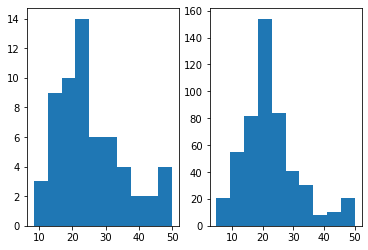

In [328]:
plt.subplot(1, 2, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plt.hist(boston_y[boston_sample])
plt.subplot(1, 2, 2)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
plt.hist(boston_y)
plt.show()

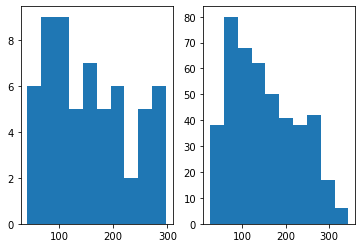

In [329]:
plt.subplot(1, 2, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plt.hist(diabetes_y[diabetes_sample])
plt.subplot(1, 2, 2)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
plt.hist(diabetes_y)
plt.show()

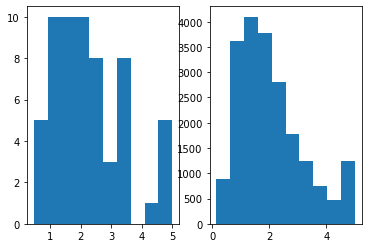

In [330]:
plt.subplot(1, 2, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plt.hist(california_y[california_sample])
plt.subplot(1, 2, 2)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
plt.hist(california_y)
plt.show()

In [30]:
boston_X, boston_y = scale(boston_X[boston_sample]), boston_y[boston_sample]
diabetes_X, diabetes_y = scale(diabetes_X[diabetes_sample]), diabetes_y[diabetes_sample]
california_X , california_y = scale(california_X[california_sample]), california_y[california_sample]
fish_X, fish_y = scale(fish_X[fish_sample]), fish_y

NameError: name 'boston_sample' is not defined

In [20]:
boston_X = scale(boston_X)
diabetes_X = scale(diabetes_X)
california_X , california_y = scale(california_X[california_sample]), california_y[california_sample]
fish_X = scale(fish_X)

In [21]:
def exps(features, target, name):
    dump_results(nested_cv(features, target), results_dir + name +'_nestedCV.pickle')
    dump_results(naive_approach(features, target, k_value=5), results_dir + name +'_10CV.pickle')
    dump_results(naive_approach(features, target, k_value=10), results_dir + name +'_5CV.pickle')

In [ ]:
exps(boston_X,boston_y, 'boston')

In [ ]:
exps(diabetes_X,diabetes_y, 'diabetes')

In [ ]:
exps(california_X,california_y, 'california')

In [ ]:
exps(fish_X,fish_y, 'fish')

----OLS------
----RIDGE------
----LASSO------
----PLS------
----SVR------


#### Analyzing research datasets results

In [280]:
boston_results = load_dumped_results('../../results/modeling/research_datasets/diabetes_nestedCV.pickle')
boston_results = extract_nestedcv_results(boston_results)

In [281]:
boston_results['test_r2']

,OLS,RIDGE,LASSO,PLS,SVR
0,-0.831610,-0.816851,-0.696686,-1.094875,-0.964619
1,-0.150077,-0.070626,-0.043684,0.085782,-0.134195
2,0.234064,0.333155,0.187814,0.307392,0.356545
3,-0.067704,-0.035376,0.086306,-0.192228,-1.236976
4,-0.508925,-0.015675,0.160921,-0.272310,-0.024799
5,0.207676,0.482278,0.334519,0.493971,0.548504
6,0.460419,0.459261,0.449243,0.530806,0.501201
7,-0.636812,-0.665636,-0.702651,-0.769241,-0.112754
8,0.012135,0.099744,0.026155,-0.020585,0.018237
9,0.433217,0.417408,0.312093,0.518336,0.471164
